## Klasifikasi Jari Menggunakan CNN
### Michael Effendy (OrionSeeker)
Link Repo: https://github.com/OrionSeeker/Klasifikasi-Jumlah-Jari-CNN

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
os.listdir("./Preprocessing_RGB")

['finger_1', 'finger_2', 'finger_3', 'finger_4', 'finger_5']

In [3]:
base_dir = "./Preprocessing_RGB/"
splitfolders.ratio(base_dir, output='./Dataset_split4_2', seed=1337, ratio=(.7, .3))

train_dir = os.path.join("./Dataset_split4_2", "train")
validation_dir = os.path.join("./Dataset_split4_2", "val")

Copying files: 2099 files [00:04, 511.45 files/s]


In [4]:
def check_and_remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f"File rusak ditemukan dan dihapus: {img_path}")
                os.remove(img_path)

check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(validation_dir)

print("Pemeriksaan dan penghapusan file rusak selesai.")

Pemeriksaan dan penghapusan file rusak selesai.


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True, 
                                brightness_range=[0.8,1.2],
                                fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 1468 images belonging to 5 classes.
Found 631 images belonging to 5 classes.


In [6]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoint_CNNF4_2.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

In [11]:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
history = model.fit(
    train_generator,
    epochs = 200,
    validation_data = validation_generator,
    verbose=1,
    callbacks=[reduce_on_plateau, early_stop, checkpoint]
)

Epoch 1/200
46/46 [==============================] - ETA: 0s - loss: 19.5532 - accuracy: 0.2064
Epoch 1: val_accuracy improved from -inf to 0.20444, saving model to Checkpoint_CNNF4_2.keras
46/46 [==============================] - 24s 285ms/step - loss: 19.5532 - accuracy: 0.2064 - val_loss: 14.4713 - val_accuracy: 0.2044 - lr: 0.0010
Epoch 2/200
46/46 [==============================] - ETA: 0s - loss: 13.3484 - accuracy: 0.1846
Epoch 2: val_accuracy did not improve from 0.20444
46/46 [==============================] - 9s 204ms/step - loss: 13.3484 - accuracy: 0.1846 - val_loss: 11.4032 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 3/200
46/46 [==============================] - ETA: 0s - loss: 10.1183 - accuracy: 0.2139
Epoch 3: val_accuracy improved from 0.20444 to 0.20919, saving model to Checkpoint_CNNF4_2.keras
46/46 [==============================] - 9s 197ms/step - loss: 10.1183 - accuracy: 0.2139 - val_loss: 8.8086 - val_accuracy: 0.2092 - lr: 0.0010
Epoch 4/200
46/46 [=============

In [13]:
# model = tf.keras.models.load_model('Model_CNNF4_2fix.keras')

In [14]:
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss: %f" % loss)
print("Validation Accuracy: %f" % accuracy)

20/20 [==============================] - 1s 37ms/step - loss: 0.7762 - accuracy: 0.7861
Validation Loss: 0.776211
Validation Accuracy: 0.786054


20/20 [==============================] - 1s 33ms/step - loss: 0.7762 - accuracy: 0.7861


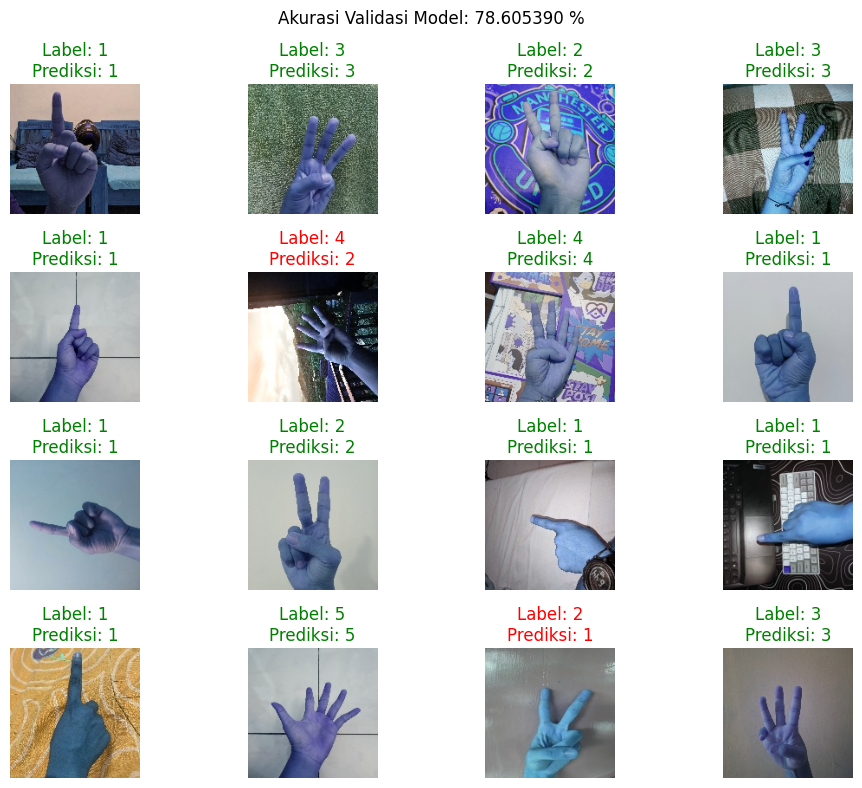

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X_batch, y_batch = next(validation_generator)

for img in X_batch:
    img = np.uint8(img)

preds = model.predict(X_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_batch, axis=1)

daftar_label = ['1', '2', '3', '4', '5']
loss, accuracy = model.evaluate(validation_generator)
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
fig.suptitle("Akurasi Validasi Model: %f %%" % (accuracy*100))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_batch[i])
    ax.axis('off')

    true_label = daftar_label[true_classes[i]]
    pred_label = daftar_label[pred_classes[i]]

    font_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"Label: {true_label}\nPrediksi: {pred_label}", color=font_color)

plt.tight_layout()
plt.show()